# 원, 삼각형, 사각형 구분
 - 어려운 테스트 문제를 데이터 부풀리기를 이용하여 많이 생성
 - 기존 cnn 모델 사용

In [1]:
from google.colab import files
up = files.upload()

Saving hard_handwriting_shape.zip to hard_handwriting_shape.zip


In [2]:
!unzip hard_handwriting_shape.zip -d hard_handwriting

Archive:  hard_handwriting_shape.zip
  inflating: hard_handwriting/test/circle/circle021.png  
  inflating: hard_handwriting/test/circle/circle022.png  
  inflating: hard_handwriting/test/circle/circle023.png  
  inflating: hard_handwriting/test/circle/circle024.png  
  inflating: hard_handwriting/test/circle/circle025.png  
  inflating: hard_handwriting/test/rectangle/rectangle021.png  
  inflating: hard_handwriting/test/rectangle/rectangle022.png  
  inflating: hard_handwriting/test/rectangle/rectangle023.png  
  inflating: hard_handwriting/test/rectangle/rectangle024.png  
  inflating: hard_handwriting/test/rectangle/rectangle025.png  
  inflating: hard_handwriting/test/triangle/triangle021.png  
  inflating: hard_handwriting/test/triangle/triangle022.png  
  inflating: hard_handwriting/test/triangle/triangle023.png  
  inflating: hard_handwriting/test/triangle/triangle024.png  
  inflating: hard_handwriting/test/triangle/triangle025.png  
  inflating: hard_handwriting/train/circle/

In [2]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

 - 데이터 생성

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255., 
rotation_range=15,  # 무작위로 이미지를 15도 이내의 범위에서 회전
width_shift_range=0.1, # 무작위로 이미지를 수평으로 변환
height_shift_range=0.1, # 무작위로 이미지를 수직으로 변환
shear_range=0.5, # 도형의 기울기
zoom_range=[0.8, 1.5], # 0.8~1.5배로 이미지를 임의로 축소, 확대
horizontal_flip=True, # 무작위로 이미지를 수평 뒤집기
vertical_flip=False, # 무작위로 이미지를 수직 뒤집기
fill_mode='nearest')

In [4]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
img = load_img('hard_handwriting/train/triangle/triangle001.png')
x = img_to_array(img)
x.shape

(24, 24, 3)

In [5]:
# x.reshape(1, 24, 24, 3) # jupyter notebook 쓸 때
x = x.reshape((1,)+ x.shape) # 다른 기타 python 라이브러리를 쓸 때
x.shape

(1, 24, 24, 3)

 - 데이터 부풀리기를 통해 만들어지는 새로운 도형 이미지

In [6]:
# 부풀린 이미지 데이터를 저장할 디렉토리 만들기
import os
if not os.path.exists('preview'): # preview라는 디렉토리가 존재하지 않으면
    os.mkdir('preview') # preview라는 디렉토리를 만들어라

In [7]:
train_datagen.flow(x, batch_size=1, save_to_dir='/preview', save_prefix='pre')

In [8]:
!ls -l preview

total 0


In [10]:
count = 0
for _ in train_datagen.flow(x, batch_size=1, save_to_dir='./preview', save_prefix='pre'):
    count +=1
    if count >=30:
        break

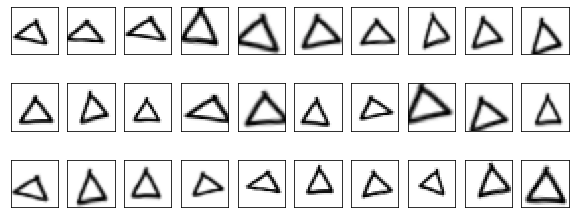

In [11]:
plt.figure(figsize =(10,4))
for  i, fname in enumerate(glob('preview/*.png')):
    img = Image.open(fname)
    plt.subplot(3, 10, i+1)
    plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.show()

 - 데이터 제너레이터

In [13]:
train_data_generator = train_datagen.flow_from_directory(
    'hard_handwriting/train', target_size = (24,24), batch_size=3, class_mode='categorical'
)

Found 45 images belonging to 3 classes.


In [14]:
test_datagen = ImageDataGenerator(rescale=1/255.)
test_data_generator = test_datagen.flow_from_directory(
     'hard_handwriting/train', target_size = (24,24), batch_size=3, class_mode='categorical')

Found 45 images belonging to 3 classes.


모델 정의/설정/학습/평가

In [15]:
import numpy as np
import tensorflow as tf
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [17]:
model = Sequential([ 
    Conv2D(32, (3,3), input_shape=(24,24,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               819328    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

In [18]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [19]:
model.fit(
    test_data_generator, steps_per_epoch=15, epochs=300,
    validation_data=test_data_generator, validation_steps=5
)

Epoch 1/300
15/15 [==============================] - 3s 18ms/step - loss: 0.8930 - accuracy: 0.6444 - val_loss: 0.5108 - val_accuracy: 0.5333
Epoch 2/300
15/15 [==============================] - 0s 8ms/step - loss: 0.1867 - accuracy: 0.9333 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 3/300
15/15 [==============================] - 0s 8ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 8.9791e-04 - val_accuracy: 1.0000
Epoch 4/300
15/15 [==============================] - 0s 10ms/step - loss: 9.1552e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/300
15/15 [==============================] - 0s 8ms/step - loss: 5.0494e-04 - accuracy: 1.0000 - val_loss: 2.1279e-04 - val_accuracy: 1.0000
Epoch 6/300
15/15 [==============================] - 0s 8ms/step - loss: 2.5093e-04 - accuracy: 1.0000 - val_loss: 1.4111e-04 - val_accuracy: 1.0000
Epoch 7/300
15/15 [==============================] - 0s 8ms/step - loss: 1.8938e-04 - accuracy: 1.0000 - val_loss: 1.1130e-04 - 

In [20]:
model.evaluate(test_data_generator)

15/15 [==============================] - 0s 4ms/step - loss: 2.6491e-09 - accuracy: 1.0000


[2.6490951654523087e-09, 1.0]